In [134]:
import nltk
nltk.download('stopwords')

import os
import re
import numpy as np
import pandas as pd
import requests
import urllib.request
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from attention import AttentionLayer
from summa.summarizer import summarize
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate

[nltk_data] Downloading package stopwords to /home/ssac14/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.  
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.  
  
  
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  
모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.  
  
  
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.  
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.  

# 1. 데이터 수집하기

In [161]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [162]:
data.sample(5)

,headlines,text
18344,Congress posts Rahul's Fitbit data; says walke...,Congress has posted a screenshot on Twitter of...
60048,Cop folds hands before 7-member family riding ...,A photograph of Bihar Station House Officer As...
81492,Couple removes stuck clock that was ringing da...,An American couple has finally removed an alar...
32963,Retired army officer gets war injury pension a...,The Armed Forces Tribunal (AFT) has ruled that...
45030,India has highest percentage of women commerci...,India has the highest percentage of women comm...


<br><br><br><br><br><br>

# 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

## 2-1. 중복 확인 및 제거

In [163]:
print(len(data))
print(data['headlines'].nunique())
print(data['text'].nunique())

98401
98280
98360


In [164]:
# 헤드라인은 중복될 수 있으나 text는 중복되면 안되기 때문에
data.drop_duplicates(subset=['text'], inplace=True)
print(len(data))

98360


## 2-2. null 값 확인 

In [165]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 2-3. 텍스트 정규화

In [166]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


In [167]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b", "",sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자는 공백으로 처리
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m 3개 이상 -> 2개로 변경
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

In [168]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않음

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [106]:
clean_text = []

# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [107]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [108]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 2-4. 샘플의 최대 길이 정하기

In [109]:
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print(f'text 최소 길이 : {np.min(text_len)}')
print(f'text 최대 길이 : {np.max(text_len)}')
print(f'text 평균 길이 : {np.mean(text_len)}')
print(f'headline 최소 길이 : {np.min(headline_len)}')
print(f'headline 최대 길이 : {np.max(headline_len)}')
print(f'headline 평균 길이 : {np.mean(headline_len)}')

text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.09968483123221
headline 최소 길이 : 1
headline 최대 길이 : 16
headline 평균 길이 : 9.299532330215534


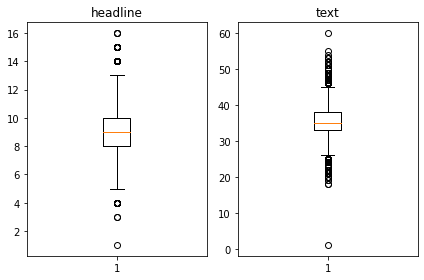

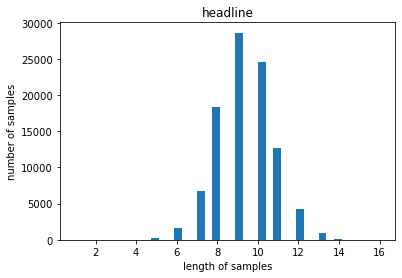

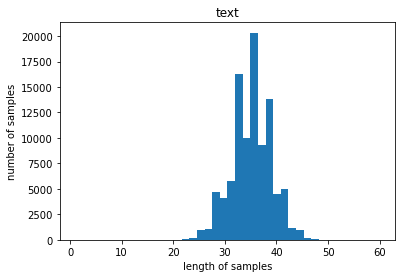

In [110]:
plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [111]:
text_max_len = 42
headline_max_len = 12

In [112]:
def below_threshold_len(max_len, len_list):
    cnt = 0
    for length in len_list:
        if length <= max_len:
            cnt += 1
    print(f'전체 샘풀 중 길이가 {max_len}이하인 샘플의 비율 : {cnt/len(len_list)}')

In [113]:
below_threshold_len(text_max_len, text_len)
below_threshold_len(headline_max_len, headline_len)

전체 샘풀 중 길이가 42이하인 샘플의 비율 : 0.9750305002033347
전체 샘풀 중 길이가 12이하인 샘플의 비율 : 0.9880337535583571


In [114]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print(len(data))
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print(len(data))

95904
94754


## 2-5. 시작토큰과 종료토큰 추가

In [115]:
# decoder - 시작토큰 입력받아 문장 생성하기 시작하고, 종료 토큰을 예측한 순간 문장생성 stop
# headlines데이터에 시작토큰과 종료토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head(3)

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...


In [116]:
encoder_input = np.array(data['text'])            # 인코더 입력
decoder_input = np.array(data['decoder_input'])   # 디코더 입력
decoder_target = np.array(data['decoder_target']) # 디코더 레이블

## 2-6. train, test data 분리

In [117]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만듬
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [118]:
# 위 정수시퀀스를 이용해서 다시 데이터의 샘플 순서를 정의해줌
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [119]:
# train, test 8:2 비율로 분리
n_of_val = int(len(encoder_input) * 0.2)
print('number of test data :', n_of_val)

encoder_input_train = encoder_input[ : -n_of_val]
decoder_input_train = decoder_input[ : -n_of_val]
decoder_target_train = decoder_target[ :-n_of_val]

encoder_input_test = encoder_input[-n_of_val : ]
decoder_input_test = decoder_input[-n_of_val : ]
decoder_target_test = decoder_target[-n_of_val : ]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

number of test data : 18950
훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


## 2-7. 단어 집합(vocaburary) 만들기

In [120]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)  # 입력된 데이터로부터 단어 집합 생성

In [121]:
src_tokenizer.word_index

{'said': 1,
 'india': 2,
 'year': 3,
 'added': 4,
 'us': 5,
 'also': 6,
 'government': 7,
 'first': 8,
 'police': 9,
 'people': 10,
 'indian': 11,
 'two': 12,
 'old': 13,
 'film': 14,
 'minister': 15,
 'president': 16,
 'one': 17,
 'crore': 18,
 'court': 19,
 'world': 20,
 'state': 21,
 'reportedly': 22,
 'years': 23,
 'would': 24,
 'new': 25,
 'time': 26,
 'delhi': 27,
 'former': 28,
 'last': 29,
 'reports': 30,
 'three': 31,
 'company': 32,
 'earlier': 33,
 'congress': 34,
 'like': 35,
 'man': 36,
 'bjp': 37,
 'based': 38,
 'country': 39,
 'claimed': 40,
 'accused': 41,
 'day': 42,
 'team': 43,
 'trump': 44,
 'pakistan': 45,
 'chief': 46,
 'modi': 47,
 'singh': 48,
 'actor': 49,
 'pm': 50,
 'according': 51,
 'women': 52,
 'allegedly': 53,
 'made': 54,
 'million': 55,
 'tuesday': 56,
 'party': 57,
 'wednesday': 58,
 'comes': 59,
 'lakh': 60,
 'monday': 61,
 'friday': 62,
 'woman': 63,
 'pradesh': 64,
 'called': 65,
 'around': 66,
 'video': 67,
 'thursday': 68,
 'asked': 69,
 'billion'

In [122]:
# 빈도수가 낮은 단어들은 훈련데이터에서 제외시키기
threshold = 7
total_cnt = len(src_tokenizer.word_index)  # 67924

rare_cnt = 0    # 등장빈도수가 threshold보다 작은 단어 카운트
total_freq = 0  # 훈련데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in src_tokenizer.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
print(f'단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 {total_cnt - rare_cnt}')
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 67881
등장 빈도가 6번 이하인 희귀 단어의 수 : 46187
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21694
단어 집합에서 희귀 단어의 비율 : 68.04113080243367
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 3.5483314585109498


In [123]:
src_vocab = total_cnt - rare_cnt
print(src_vocab)
src_tokenizer = Tokenizer(num_words=src_vocab)  # 가장 빈도가 높은 src_vocap개의 단어만 선택하도록 tokenizer 객체 생성
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 인덱스 구축

21694


In [124]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3494, 7909, 843, 37, 16, 974, 250, 1, 2, 2196, 11227, 2166, 17, 225, 7648, 843, 4, 2196, 11227, 2166, 2, 2454, 134, 54, 2965, 18984, 6, 1, 34, 2237, 2118, 2578], [130, 539, 505, 278, 110, 994, 555, 457, 3, 247, 303, 154, 4974, 385, 457, 674, 302, 23, 33, 303, 154, 934, 110, 385, 457, 994, 110, 674], [1146, 605, 15, 1876, 1441, 58, 1182, 481, 1806, 3, 13, 470, 153, 5472, 2866, 255, 1059, 1800, 2, 12262, 1169, 2, 1086, 42, 2713, 481, 1806, 373, 2588, 5, 1876, 78, 421, 3]]


In [125]:
# headlines도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index)

rare_cnt = 0    # 등장빈도수가 threshold보다 작은 단어 개수 카운트
total_freq = 0  # 훈련데이터의 전체 단어 빈도수 총합
rare_freq = 0   # 등장빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

for key,value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수 : {rare_cnt}')
print(f'단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 {total_cnt - rare_cnt}')
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 29580
등장 빈도가 5번 이하인 희귀 단어의 수 : 19353
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10227
단어 집합에서 희귀 단어의 비율 : 65.4259634888438
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 4.754753788683042


In [126]:
tar_vocab = total_cnt - rare_cnt
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 진행되었는지 샘플 출력
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[1, 164, 6680, 25, 2158, 718, 260, 7, 742], [1, 800, 68, 4, 647, 1512, 382, 4, 60], [1, 1582, 3228, 958, 1049, 3, 59, 1513, 5, 184, 1118, 1198], [1, 15, 3, 184, 1755, 1811, 7, 618, 1403, 53], [1, 982, 2159, 3084, 3, 1785, 215, 101, 14, 2609]]
decoder  [[164, 6680, 25, 2158, 718, 260, 7, 742, 2], [800, 68, 4, 647, 1512, 382, 4, 60, 2], [1582, 3228, 958, 1049, 3, 59, 1513, 5, 184, 1118, 1198, 2], [15, 3, 184, 1755, 1811, 7, 618, 1403, 53, 2], [982, 2159, 3084, 3, 1785, 215, 101, 14, 2609, 2]]


In [127]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 2-8. 패딩하기
서로 다른 길이의 샘플들을 병렬처리하기 위해 같은 길이로 맞춰줌

In [128]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

<br><br><br><br><br><br>

# 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.



1. 원문을 첫번째 RNN인 인코더로 입력한다.
2. 인코더는 입력받은 원문을 하나의 고정된 벡터로 변환한다. 이 벡터를 컨텍스트 벡터(문맥정보를 가지고 있는 벡터)라고 한다.
3. 두번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한단어씩 생성내서 요약문장을 완성한다.

  
- 문제: RNN계열의 인공신경망(RNN, LSTM)의 한계로 컨텍스트 정보에 입력시퀀스의 많은 정보손실 발생
- 해결: 어텐션메커니즘
  - 인코더의 모든 스텝의 hidden state정보가 컨텍스트 벡터에 전부 반영
  - 모든 hidden state가 동일한 비중이 아니라, 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산
  

## 3-1. 모델설계

In [137]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len, ))

# 인코더 임베딩층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None, ))

# 디코더 임베딩층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더 출력층 - 이 출력층에서는 tar_vocab 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야함
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 42, 128)      2776832     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  [(None, 42, 256), (N 394240      embedding_10[0][0]               
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

## 3-2. 모델 훈련

In [133]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(x=[encoder_input_train, decoder_input_train],
                   y=decoder_target_train,
                   validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                   batch_size=512,
                   callbacks=[es],
                   epochs=50)

Epoch 1/50
149/149 [==============================] - 613s 4s/step - loss: 5.2243 - val_loss: 5.0356
Epoch 2/50
149/149 [==============================] - 999s 7s/step - loss: 4.9130 - val_loss: 4.7944
Epoch 3/50
149/149 [==============================] - 482s 3s/step - loss: 4.6508 - val_loss: 4.6116
Epoch 4/50
149/149 [==============================] - 482s 3s/step - loss: 4.4343 - val_loss: 4.4636
Epoch 5/50
149/149 [==============================] - 482s 3s/step - loss: 4.2570 - val_loss: 4.3122
Epoch 6/50
149/149 [==============================] - 481s 3s/step - loss: 4.1064 - val_loss: 4.2236
Epoch 7/50
149/149 [==============================] - 482s 3s/step - loss: 3.9749 - val_loss: 4.1706
Epoch 8/50
149/149 [==============================] - 482s 3s/step - loss: 3.8590 - val_loss: 4.0989
Epoch 9/50
149/149 [==============================] - 482s 3s/step - loss: 3.7540 - val_loss: 4.0503
Epoch 10/50
149/149 [==============================] - 482s 3s/step - loss: 3.6562 - val_lo

## 3-3. 인퍼런스 모델 구현

In [135]:
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어를 얻음

In [138]:
# 정답이 없는 인퍼런스 단계에서는 만들어야할 문장의 길이만큼 디코더가 반복구조로
# 동작해야하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야함
# 이때는 인코더 모델과 디코더 모델을 분리해서 설계함

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [139]:
encoder_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 42, 128)           2776832   
_________________________________________________________________
lstm_19 (LSTM)               [(None, 42, 256), (None,  394240    
_________________________________________________________________
lstm_20 (LSTM)               [(None, 42, 256), (None,  525312    
_________________________________________________________________
lstm_21 (LSTM)               [(None, 42, 256), (None,  525312    
Total params: 4,221,696
Trainable params: 4,221,696
Non-trainable params: 0
_________________________________________________________________


In [144]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

<br><br><br><br><br><br>

# 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [141]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [145]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보기
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : icc trolled pakistani fan accused biased towards india icc tweeted photo indian fans cheering india sri lanka match pakistani fan replied dare stop kissing india minutes minutes icc responded reference pakistan win day earlier 
실제 요약 : icc trolls pak fan for calling it biased towards india 
예측 요약 :  clothes bsnl anup nagasaki learnt vatican kids gabbar fugitive chant chant


원문 : many three indian origin scientists elected royal society world oldest scientific academy continuous existence scientists krishna chatterjee subhash society announced election scientists foreign members contribution science 
실제 요약 : indian origin scientists elected of royal society 
예측 요약 :  clothes hrs lahore mcgrath sold toy fortune fortune brussels ton memories


원문 : india women team captain harmanpreet kaur named player year australia women big bash league team sydney thunder harmanpreet earlier become first indian cricketer play australia big bash league picked team last year played matches team sco

예측 요약 :  clothes bsnl anup minority contingent shatabdi inaction sunday reunites hanuman loving


원문 : customs officials arrested five men smuggling gold worth lakh separate cases delhi airport first case three passengers carrying gold bar arrested arrival sharjah statement officials said two men carrying gold plates pasted beneath luggage trolley held arrival dubai case 
실제 요약 : five men held for smuggling gold worth at delhi airport 
예측 요약 :  ashamed stayed johnny johnny bhavan gaikwad divide spotted waqf chhota launched


원문 : family georgia us adopted seven siblings foster care nearly years clark husband already biological son decided want adopt years ago love family difficult would change said 
실제 요약 : family adopts siblings who were in care for yrs 
예측 요약 :  clothes rivers mistakenly busted builds builds numbers diseases institute pod rcb


원문 : lalu prasad yadav elder son bihar health minister tej pratap yadav sunday said pm narendra modi chief minister yogi adityanath character

예측 요약 :  ashamed brahm francisco wage stabbing maa like gaga involvement involvement frozen


원문 : sharing picture children shweta nanda abhishek bachchan sonam kapoor wedding amitabh bachchan wrote mere dil mere ke apples entire fruit basket eye seen white outfits picture abhishek seen also wearing turban 
실제 요약 : not fruit of my eye big on children pic 
예측 요약 :  clothes clothes attempting sq belts machine travel cuba decline stab adidas


원문 : west bengal chief minister mamata banerjee friday unveiled official emblem state government emblem featuring biswa bangla logo designed chief minister unveiling banerjee address said proposal seeking change name state also sent centre 
실제 요약 : mamata banerjee unveils official of west bengal govt 
예측 요약 :  ashamed brahm arjuna taapsee amid drag drag parole fifties kar patekar


원문 : indian space research organisation successfully launched th satellite friday sriharikota andhra pradesh along satellites three satellites india remaining foreign inc

그다지 좋지 못한 결과를 보임
- 같은 단어 반복  
ex)ashamed arjuna harley harley harley considering germans farming assistant avenge avenge

방법
- seq2seq + 어텐션 조합을 좀 더 좋게 수정하기
- 빔서치(beam search)
- 사전 훈련된 워드 임베딩(pre-trained word embedding)
- 인코더-디코더 자체의 구조를 새로이 변경하는 트랜스포머(transformer)

<br><br><br><br><br><br>

# 5. Summa을 이용해서 추출적 요약해보기

In [188]:
input_text = data['text']

In [195]:
for _ in range(10):
    random_n = np.random.randint(len(input_text))
    print("원문 : ", input_text[random_n])
#     print("요약 : ", summarize(input_text[random_n], ratio=0.5))
    print("요약 : ", summarize(input_text[random_n], words=20))
    print("\n")

원문 :  Mourning the sudden demise of actress Sridevi, Priyanka Chopra tweeted, "I have no words. Condolences to everyone who loved Sridevi. A dark day." Sushmita Sen tweeted, "I am in shock... can't stop crying." Katrina Kaif shared Sridevi's picture on Instagram and wrote, "My favorite actress...a legend... unbelievable tragedy this is." AR Rahman and Farhan Akhtar also shared condolence messages.
요약 :  Mourning the sudden demise of actress Sridevi, Priyanka Chopra tweeted, "I have no words.


원문 :  Ahead of the general elections in Pakistan, cricketer-turned-politician Imran Khan has said, "You contest elections to win. You don't contest elections to be a good boy." Adding that he wants to win, the Pakistan Tehreek-e-Insaf chief said, "You need money and thousands of trained polling agents who can bring out people on the day of elections."
요약 :  Ahead of the general elections in Pakistan, cricketer-turned-politician Imran Khan has said, "You contest elections to win.


원문 :  Russia wi